In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing._data import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [ ]:
TrainingData = pd.read_csv('../data/01 Raw/icml_face_data.csv')
TrainingData


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [ ]:
TrainingData.columns = TrainingData.columns.map(lambda x: x.lower().strip())

In [ ]:
TrainingData

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [ ]:
FinalTestData = pd.read_pickle('../data/02 Processed/testData.pkl')

In [ ]:
FinalTestData

,emotion,usage,pixels
23022,3,Training,226 220 207 191 178 162 158 146 168 139 146 14...
2233,2,Training,235 236 233 141 92 116 103 80 67 75 71 55 65 6...
15400,3,Training,69 63 58 52 48 44 45 49 55 61 47 39 100 70 27 ...
10792,3,Training,168 161 166 165 165 177 181 180 174 171 166 16...
27856,3,Training,94 104 105 119 120 128 160 158 160 158 159 149...
...,...,...,...
3387,0,Training,45 41 44 47 49 50 69 113 143 143 145 152 161 1...
33620,6,PrivateTest,214 219 221 220 221 220 220 223 208 131 107 11...
26225,6,Training,157 114 63 18 10 10 23 11 8 24 26 11 11 11 19 ...
34258,2,PrivateTest,115 120 125 130 138 143 145 146 148 148 147 14...


In [ ]:
TrainingData[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [ ]:
TrainingData = pd.read_pickle('../data/02 Processed/train.pkl')
FinalTestData = pd.read_pickle('../data/02 Processed/testData.pkl')
FinalTestData.drop(columns = 'usage', inplace = True)
# s = TrainingData.iloc[:1000].copy()
# del TrainingData
# TrainingData = s.copy()
# del s

FinalTestData.shape, TrainingData.shape
TrainingDataCheckPoint = TrainingData.copy()

In [ ]:
big,small = train_test_split(TrainingData, test_size=0.02, stratify=TrainingData['emotion'], random_state=42)

<Axes: xlabel='emotion'>

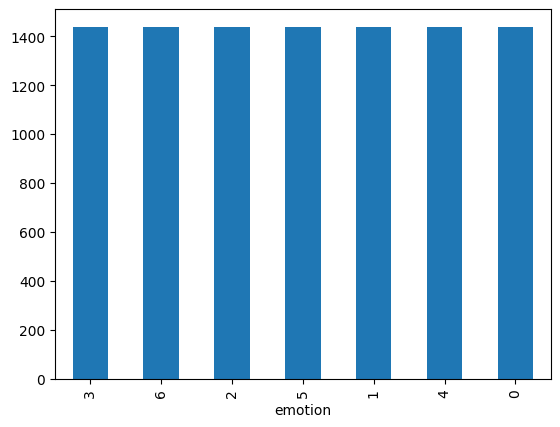

In [ ]:
small.emotion.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

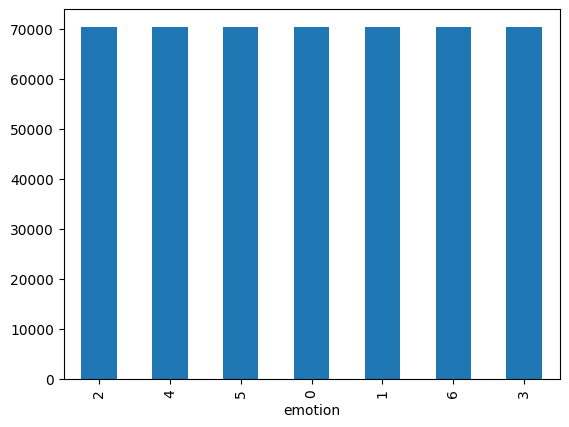

In [ ]:
big.emotion.value_counts().plot(kind='bar')

In [ ]:
TrainingData = small

In [ ]:
TrainingData = TrainingData.iloc[:5]

In [ ]:
TrainingData = TrainingDataCheckPoint.drop_duplicates().reset_index(drop=True)

In [ ]:

class CustomStandardScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
        self.__mean = None
        self.__std = None
        self.__fitted = False

    @property
    def _fitted(self)->bool:
        return self.__fitted

    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _mean(self)->np.ndarray:
        '''
        mean of the passed data
        '''
        if self.__mean is None:
            raise AttributeError("The 'fit' method must be called before accessing the mean.")
        return self.__mean

    @property
    def _std(self)->np.ndarray:
        '''
        std of the passed data
        '''
        if self.__std is None:
            raise AttributeError("The 'fit' method must be called before accessing the std.")
        return self.__std

    def fit(self, X: np.ndarray)-> 'CustomStandardScaler':
        self._fitted = True
        self.__mean = X.mean(axis=0)
        self.__std = X.std(axis=0)
        return self

    def transform(self, X: np.ndarray)-> np.ndarray:
        newX = X - self._mean
        newX = (newX / self._std) * self.sigma
        return newX+self.mu

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        newX = X - self.mu
        newX = (newX / self._std) * self.sigma
        return newX + self._mean

class CustomMinMaxScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self):
        self.__min = None
        self.__max = None
        self.__fitted = False

    @property
    def _fitted(self)->bool:
        return self.__fitted

    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _min(self)->np.ndarray:
        '''
        min of the passed data
        '''
        if self.__min is None:
            raise AttributeError("The 'fit' method must be called before accessing the min.")
        return self.__min

    @property
    def _max(self)->np.ndarray:
        '''
        max of the passed data
        '''
        if self.__max is None:
            raise AttributeError("The 'fit' method must be called before accessing the max.")
        return self.__max

    def fit(self, X: np.ndarray)-> 'CustomStandardScaler':
        self._fitted = True
        self.__min = X.min(axis=0)
        self.__max = X.max(axis=0)
        return self

    def transform(self, X: np.ndarray)-> np.ndarray:
        return (X - self._min)/(self._max - self._min)

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        return X * (self._max - self._min) + self._min

class Data(Dataset):
    _identityFunc = lambda x: x
    def __init__(self,data:pd.DataFrame, transform:transforms = None, scaler:BaseEstimator = None):
        # making them private so can't be altered
        if not scaler:
            scaler = CustomScaler(0, 0.25)

        self.__transform = transform if transform else Data._identityFunc
        self.__Y = data['emotion'].astype(int).values.tolist()
        self.__X = data.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48)
        self.__len = data.shape[0]
        try:
            self.__X = scaler.fit_transform(self.__X).astype(np.float32)
        except AttributeError:
            print("Already fit")
            self.__X = scaler.transform(self.__X).astype(np.float32)

    def __len__(self)->int:
        return self.__len

    def __getitem__(self, index)->tuple[np.ndarray,np.ndarray]:
        img:np.ndarray = self.__X[index]
        emotion:int = self.__Y[index]
        label = np.zeros((7,), dtype=np.float32)
        label[emotion] = 1
        return self.__transform(img), label

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 12 * 12, 256),
            nn.LeakyReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 100),
            nn.Sigmoid()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x



In [ ]:

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get accuracy
        predicted = outputs.argmax(axis=1)
        target = labels.argmax(axis=1)
        correct = (predicted == target).sum().item()
        accuracy = correct / labels.size(0)
    return running_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          predicted = outputs.argmax(axis=1)
          total += labels.size(0)
          correct += (predicted == labels.argmax(axis = 1)).sum().item()

    return running_loss / len(dataloader), correct / total

In [ ]:
class CustomLoss(nn.Module):
    '''
    nn.CrossEntropyLosss is annoying me the way it expects labels
    it also does the softmax part itself.

    this class expects two R^n vectors or two arrays of R^n vectors
    it then penalises the difference using negative log liklihood
    '''
    def __init__(self):
        super(CustomLoss, self).__init__()
    def forward(self, probabilites:torch.Tensor, target:torch.Tensor)->torch.Tensor:
        '''
        probabilites: R^n
        target: R^n
        '''
        # print(probabilites)
        # print(target)
        # print(probabilites.shape)
        # print(target.shape)
        return -torch.sum(target * torch.log(probabilites + 1e-10), dim=1).mean()

In [ ]:
transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
scaler = CustomStandardScaler(0, 0.25) #<- Pretty good - 37% accuracy on test set, 95% on training set

scaler.fit(TrainingData.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48))

print('making dataset')
train_data = Data(TrainingData, transform=transformers, scaler=scaler)
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
train_loader = DataLoader(train_data, shuffle = True, batch_size=503370)
test_loader = DataLoader(test_data, batch_size=7178, shuffle = True)

print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

print('backward')
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Train Accuracy: {train_accuracy:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

fitting scaler
making dataset
Already fit
Already fit
making dataloader
making model
backward
Epoch [1/100],     Train Loss: 1.9439,     Train Accuracy: 0.1427,     Test Loss: 2.0306,     Accuracy: 0.2505
Epoch [2/100],     Train Loss: 2.0309,     Train Accuracy: 0.2505,     Test Loss: 1.8869,     Accuracy: 0.1461
Epoch [3/100],     Train Loss: 1.8874,     Train Accuracy: 0.1466,     Test Loss: 1.8172,     Accuracy: 0.2505
Epoch [4/100],     Train Loss: 1.8174,     Train Accuracy: 0.2505,     Test Loss: 1.8081,     Accuracy: 0.2505
Epoch [5/100],     Train Loss: 1.8083,     Train Accuracy: 0.2505,     Test Loss: 1.8129,     Accuracy: 0.2505
Epoch [6/100],     Train Loss: 1.8129,     Train Accuracy: 0.2505,     Test Loss: 1.8066,     Accuracy: 0.2505
Epoch [7/100],     Train Loss: 1.8067,     Train Accuracy: 0.2505,     Test Loss: 1.8068,     Accuracy: 0.2505
Epoch [8/100],     Train Loss: 1.8068,     Train Accuracy: 0.2505,     Test Loss: 1.7969,     Accuracy: 0.2505
Epoch [9/100],    

In [ ]:
transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
scaler = CustomMinMaxScaler()

scaler.fit(TrainingData.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48))

print('making dataset')
train_data = Data(TrainingData, transform=transformers, scaler=scaler)
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
train_loader = DataLoader(train_data, shuffle = True, batch_size=503370)
test_loader = DataLoader(test_data, batch_size=7178, shuffle = True)

print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

print('backward')
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Train Accuracy: {train_accuracy:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

fitting scaler
making dataset
Already fit
Already fit
making dataloader
making model
backward
Epoch [1/100],     Train Loss: 2.0129,     Train Accuracy: 0.1428,     Test Loss: 2.1385,     Accuracy: 0.1728
Epoch [2/100],     Train Loss: 2.2200,     Train Accuracy: 0.1429,     Test Loss: 1.9417,     Accuracy: 0.1694
Epoch [3/100],     Train Loss: 1.9575,     Train Accuracy: 0.1428,     Test Loss: 1.9852,     Accuracy: 0.0152
Epoch [4/100],     Train Loss: 1.9497,     Train Accuracy: 0.1428,     Test Loss: 1.9615,     Accuracy: 0.1427
Epoch [5/100],     Train Loss: 1.9488,     Train Accuracy: 0.1428,     Test Loss: 1.9408,     Accuracy: 0.1427
Epoch [6/100],     Train Loss: 1.9472,     Train Accuracy: 0.1428,     Test Loss: 1.9292,     Accuracy: 0.2350
Epoch [7/100],     Train Loss: 1.9465,     Train Accuracy: 0.1490,     Test Loss: 1.9344,     Accuracy: 0.2545
Epoch [8/100],     Train Loss: 1.9489,     Train Accuracy: 0.1471,     Test Loss: 1.9481,     Accuracy: 0.0318
Epoch [9/100],    

KeyboardInterrupt: 

In [ ]:
# for images, labels in train_loader:
#     print(1)

y = model(images).argmax(axis=1)

In [ ]:
yhat = labels.argmax(axis=1)

In [ ]:
yhat

tensor([4, 3, 2,  ..., 4, 3, 1])

In [ ]:
(y == yhat).sum().item()/len(yhat)

0.9295788637266588